### Проект e-commerce

В проекте проанализированы данные и даны ответы на вопросы ниже

In [2]:
# Загрузим библиотеки и считаем анализируемые файлы
import pandas as pd 
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlencode
from datetime import datetime
# Считаем csv-файлы с яндекс диска и положим их в переменные. Столбцы с датами сразу переведем в нужный тип данных.
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
public_key_2 = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw' 
public_key_3 = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg' 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key))
final_url_2 = base_url + urlencode(dict(public_key=public_key_2)) 
final_url_3 = base_url + urlencode(dict(public_key=public_key_3)) 
response = requests.get(final_url)
response_2 = requests.get(final_url_2) 
response_3 = requests.get(final_url_3) 
download_url = response.json()['href'] 
download_url_2 = response_2.json()['href'] 
download_url_3 = response_3.json()['href'] 
# загружаем файл в df 
download_response  = requests.get(download_url) 
download_response_2 = requests.get(download_url_2) 
download_response_3 = requests.get(download_url_3) 
df_custmrs = pd.read_csv(download_url)
df_orders = pd.read_csv(download_url_2, parse_dates=['order_purchase_timestamp', 'order_approved_at', 
                                                     'order_delivered_carrier_date', 'order_delivered_customer_date',
                                                     'order_estimated_delivery_date']) 
df_items = pd.read_csv(download_url_3, parse_dates=['shipping_limit_date']) 

<b>df_custmrs</b> - таблица с уникальными идентификаторами пользователей, где 
- customer_id — позаказный идентификатор пользователя
- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя

<b>df_orders</b> —  таблица заказов, где
- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

<b> df_items </b>—  товарные позиции, входящие в заказы, где
- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

Для начала объединим таблицы с уникальными пользователями и заказами. <br>
Используем left_join, чтобы точно захватить все заказы, находящиеся в df_orders.

In [3]:
df = df_orders.merge(df_custmrs, on='customer_id', how='left')

#### Проведем EDA.<br>
Каждая строчка в объединенной таблице <b>df</b> соответствует уникальному заказу, дубли отсутствуют. <br>
Всего в объединенном датасете 99441 строчек, соответственно был совершен 99441 заказ. <br>
Пропущенные значения в данных есть в колонках:
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа, <br>
что, вероятно, связано с тем, что не все заказы были подтверждены и, соответственно, переданы в доставку.<br>
Пропущенные значения в таблице <b>items</b> отсутствуют, каждая строчка соответсвует одному товару.


---
### 1. Сколько пользователей, которые совершили покупку только один раз? 

Покупкой будем считать успешно завершенные и оплаченные заказы (order_id). <br>
Так как для каждого заказа формируется отдельная строчка, то нужно отобрать только те customer_unique_id, которые встречаются 1 раз подсчитать их количество.<br>
Кроме того, возьмём только те заказы, которые не были отменены (canceled) и не являются недоступными (unavailable)

In [4]:
counts = df['customer_unique_id'].value_counts()  # Сколько заказов совершил каждый пользователь
successful_orders = df.query("order_status not in['canceled', 'unavailable']")  # Убираем незавершенные заказы,
result = [successful_orders['customer_unique_id'].isin(counts[counts==1].index)]  # Отбираем пользователей с 1 заказом
print(f" Всего было {sum(sum(result))} пользоваталей, которые совершили только 1 заказ")

 Всего было 92001 пользоваталей, которые совершили только 1 заказ


Посмотрим на распределение количества завершенных заказов по юзерам и убедимся, что подсчитали верно

<Axes: xlabel='customer_unique_id', ylabel='count'>

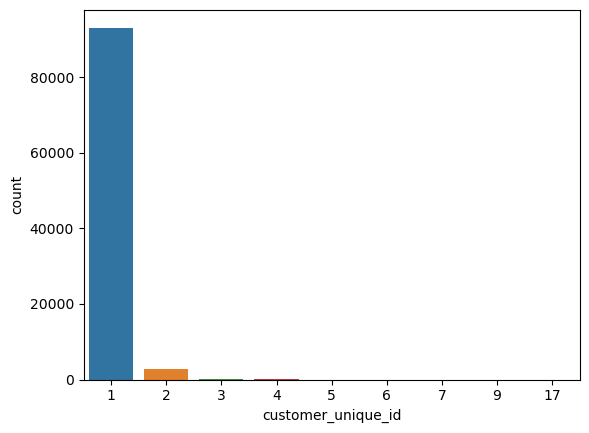

In [5]:
sns.countplot(x=counts)

---
### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?


Cначала посмотрим на распределение всех заказов, включая доставленные. Видим, что
подавляющая часть заказов доставлена.

<Axes: xlabel='order_status', ylabel='count'>

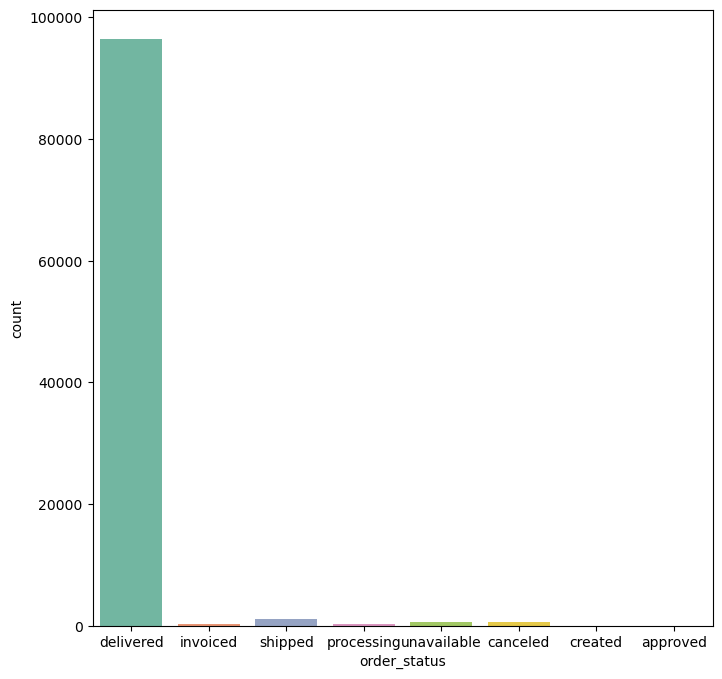

In [6]:
plt.figure(figsize=(8,8))
sns.countplot(data=df, x='order_status', palette="Set2") 

Посмотрим ближе на все заказы, которые не были доставлены (в том числе и те, которые находятся в процессе доставки).

<Axes: xlabel='order_status', ylabel='count'>

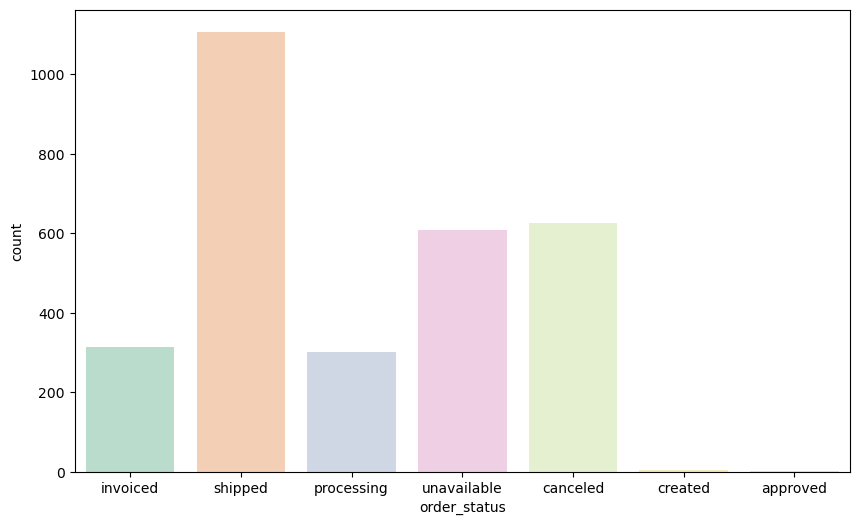

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(data=df.query('order_status != "delivered"'), x='order_status', palette="Pastel2") 

Видно, что те заказы, которые находятся в статусах
unavailable —  недоступен и
canceled —  отменён,
распределены примерно поровну. 

Из тех заказов, которые находятся в процессе обработки, большая часть находится в процессе доставки.
</br>
Примем, что не доставленными считаются заказы, имеющие ататусы "unavailable" и "canceled" и отфильтруем

In [8]:
not_delivered = df\
    .query("order_status in ['unavailable', 'canceled']")

In [9]:
df.order_purchase_timestamp.dt.to_period('M').max() - df.order_purchase_timestamp.dt.to_period('M').min()
#  Считаем количество месяцев: всего 25 месяцев

<25 * MonthEnds>

С самой ранней до самой поздней покупки прошло 25 месяцев.
Посчитаем, сколько в среднем в месяц было не доставлено заказов:

In [10]:
print(not_delivered.groupby('order_status')['order_id'].count() / 25)

order_status
canceled       25.00
unavailable    24.36
Name: order_id, dtype: float64


Ответ:
- Отменено 25
- Недоступно 24.36

Дополнительно создадим сводную heatmap-таблицу с указанием количества недоставленных заказов по месяцам и посмотрим, как распределено
количество недоставленных заказов по месяцам

In [11]:
not_delivered = not_delivered.rename(columns={"order_purchase_timestamp": "months"})
not_delivered['months'] = not_delivered.months.dt.month

Axes(0.125,0.11;0.62x0.77)


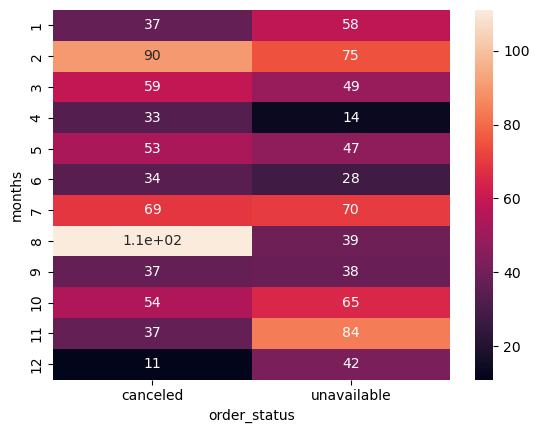

In [12]:
not_delivered = not_delivered.pivot_table('order_id', index='months', columns='order_status', aggfunc='count')
print(sns.heatmap(data=not_delivered, annot=True))  # Визуализируем

Видим, что больше всего заказов оменяется в августе, а меньше всего в декабре (возможно, это связано с влиянием праздников)

---
### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.


Для начала добавим к датафрейму данные о товарах:

In [13]:
df_full = df.merge(df_items, on='order_id', how='inner')

И создадим колонку с днями недели:

In [14]:
df_full['weekday'] = df_full.order_purchase_timestamp.dt.day_name()  #  Создаем колонку с днями недели

В данном случае не убираем незавершенные заказы, так как сам факт создания заказа уже говорит о том, что у покупателя возникло желание купить товар и мы можем делать выводы о популярности товара в этот день недели, группируем по продукту и дню недели, считаем количество заказов и сортируем.

In [15]:
product_by_weekday = df_full\
    .groupby(['product_id', 'weekday'], as_index=False)['order_id']\
    .count()\
    .rename(columns={'order_id': 'orders_count'})\
    .groupby(['weekday', 'product_id'], as_index=False)['orders_count'].max()\
    .sort_values('orders_count', ascending=False)\

print(product_by_weekday) # Выводим, в какой день недели каждый товар чаще всего покупается

         weekday                        product_id  orders_count
54190  Wednesday  422879e10f46682990de24d770e7f83d            93
14535     Monday  99a4788cb24856965c36a24e339b6058            92
39349   Thursday  aca2eb7d00ea1a7b8ebd4e68314663af            89
5918      Friday  aca2eb7d00ea1a7b8ebd4e68314663af            87
48624    Tuesday  aca2eb7d00ea1a7b8ebd4e68314663af            85
...          ...                               ...           ...
23997   Saturday  c7d729c7966df13084efeade5576dfef             1
23998   Saturday  c7d75b3bafed2b1d9475c4876b1c46b8             1
23999   Saturday  c7db42c313bd0a455af61d77976dce18             1
24000   Saturday  c7e02747ef9366a4fb7f4ac4fd261c36             1
61229  Wednesday  fffe9eeff12fcbd74a2f2b007dde0c58             1

[61230 rows x 3 columns]


Визуализируем распределение покупок по дням недели <br>
В визуализацию не выводим наименования продуктов, так как их слишком много

<Axes: xlabel='weekday', ylabel='orders_count'>

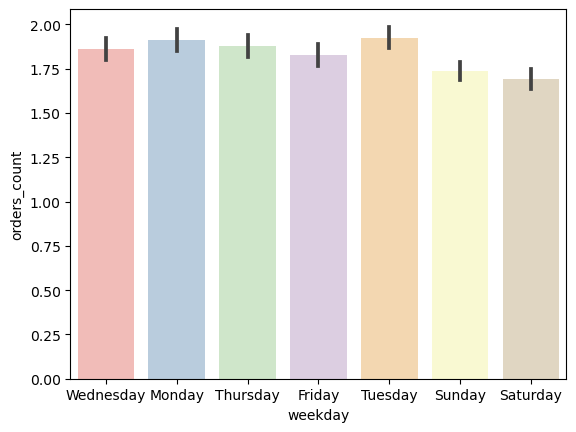

In [16]:
sns.barplot(data=product_by_weekday, x='weekday', y='orders_count', palette="Pastel1")

---
### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
>Не стоит забывать, что внутри месяца может быть не целое количество недель. <br>
> Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.
<br>
<br>
<br>

Добавим колонку с месяцем:

In [17]:
df['month'] = df.order_purchase_timestamp.dt.to_period("M")

Группируем по месяцам и покупателям, убираем незавершенные заказы. Для расчета по неделям число дней в месяце делим на 7 и сортируем по убыванию

In [18]:
orders_per_week_by_month = df\
    .query("order_status not in['canceled', 'unavailable']")\
    .groupby(['month', 'customer_unique_id'], as_index=False)['order_id'].count()
orders_per_week_by_month['weeks_in_month'] = orders_per_week_by_month.month.dt.daysinmonth / 7
orders_per_week_by_month['orders_per_week'] = orders_per_week_by_month.order_id\
                                            / orders_per_week_by_month.weeks_in_month
orders_per_week_by_month.sort_values('orders_per_week', ascending=False)
orders_per_week_by_month

,month,customer_unique_id,order_id,weeks_in_month,orders_per_week
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,1,4.285714,0.233333
1,2016-09,b7d76e111c89f7ebf14761390f0f7d17,1,4.285714,0.233333
2,2016-10,0032c76b20340da25249092a268ce66c,1,4.428571,0.225806
3,2016-10,01f156677184504063bd19739f924af1,1,4.428571,0.225806
4,2016-10,0313291a6f4f16df04dcf819d88c38ef,1,4.428571,0.225806
...,...,...,...,...,...
96864,2018-08,ffc4e1cd8aa220763480d0a18157c45d,1,4.428571,0.225806
96865,2018-08,ffe204b1bb8026741b839085b2fd10f2,1,4.428571,0.225806
96866,2018-08,ffec490ab531184a483efe2eedd68908,1,4.428571,0.225806
96867,2018-08,fff96bc586f78b1f070da28c4977e810,1,4.428571,0.225806


Дополнительно, взглянем на распределение общего количества заказов по месяцам, а также количества заказов на пользователя в неделю 

Text(0, 0.5, 'Заказы в неделю на пользователя')

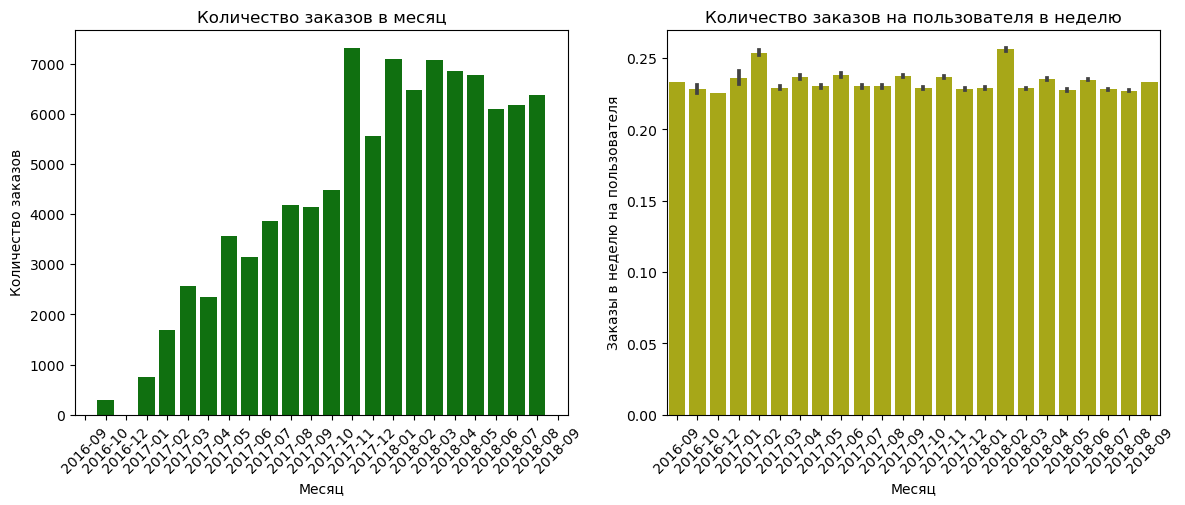

In [19]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

sns.countplot(data=orders_per_week_by_month, x='month', ax=axes[0], color="g")
axes[0].set_title("Количество заказов в месяц")
axes[0].set_xlabel("Месяц")
axes[0].set_ylabel("Количество заказов")
axes[0].tick_params(axis = 'x', labelrotation=45)

sns.barplot(data=orders_per_week_by_month, x='month', y='orders_per_week', ax=axes[1], color = "y") 
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].set_title("Количество заказов на пользователя в неделю")
axes[1].set_xlabel("Месяц")
axes[1].set_ylabel("Заказы в неделю на пользователя")


А также количества заказов в неделю по месяцам

---
### 5. Используя pandas, проведи когортный анализ пользователей.
> В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 


Пользователей поделим на когорты по месяцу создания первого заказа

In [20]:
df_full['order_month'] = df_full.order_purchase_timestamp.dt.to_period('M') 
# Создаем колонку с месяцем создания заказа для каждой строчки

df_full['first_order_month'] = df_full\
    .groupby('customer_unique_id')['order_purchase_timestamp']\
    .transform('min').dt.to_period('M') # Создаем колонку с месяцем создания первого заказа для каждого клиента


Создадим датафрейм с когортами:<br>
1) Оставим только 2017 год и неотмененные заказы<br>
2) Создадим когорты по месяцу создания первого заказа<br>

In [21]:
cohorts = df_full\
    .query("first_order_month >= '2017-01' and first_order_month <= '2017-12' and order_status not in['canceled', 'unavailable']")\
    .groupby(['first_order_month', 'order_month'])\
    .agg({'customer_unique_id': 'nunique', 'order_id': 'nunique'})\
    .reset_index()\
    .rename(columns={'customer_unique_id': 'unique_customers_count', 'order_id': 'orders_count'} )


Посчитаем <b>retention rate</b>. Retention rate определяется по формуле: <br>
CRR = ((Кол-во клиентов на конец периода - Кол-во клиентов, которые пришли за период) / Кол-во клиентов на нач. периода) *100% <br>

Так как непосредственно CRR считается для модели бизнеса, где клиенту необходимо совершить действие, чтобы отказаться от 
подписки/товара, то определяться будет сходная метрика Repeat <b>purchase rate (RPR) </b>

Для расчёта возраста когорты и retention разделим весь период на отрезки в 1 месяц и создадим сводную таблицу для отражения retention 

In [22]:

cohorts['period_number'] = (cohorts['order_month'].astype('int64') - cohorts['first_order_month'].astype('int64')) 
# делим весь период на отрезки в 1 месяц
cohorts_pivot = cohorts.pivot_table(index='first_order_month', columns='period_number', values='unique_customers_count')
# Создаем сводную таблицу для отражения retention 
cohort_sizes = cohorts_pivot.iloc[:,0]
retention = cohorts_pivot.divide(cohort_sizes, axis=0) # Рассчитываем retention (RPR)


Посмотрим на получившуюся heatmap-таблицу Retention

<Axes: xlabel='period_number', ylabel='first_order_month'>

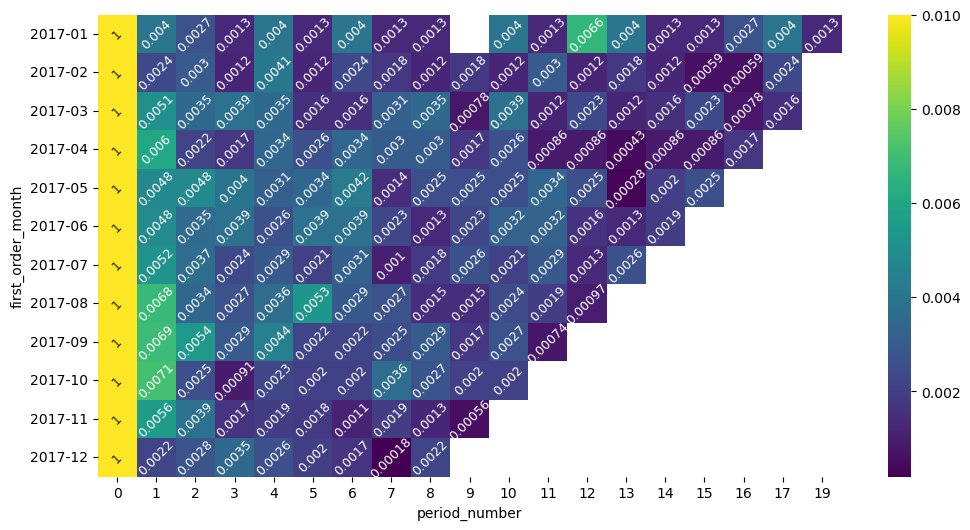

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=True, vmax=0.01, cmap="viridis", annot_kws={"rotation": 45, "fontsize": 9})

Выберем когорту с самым высоким retention на 3-й месяц


In [24]:
max_retention_cohort = retention.loc[:, 3].idxmax()
max_retention_cohort

Period('2017-05', 'M')

Ответ: когорта с самым высоким retention на 3й месяц совершила первуюю покупку в мае 2017

### 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
> В кластеризации нужно выбрать следующие метрики:<br> R - время от последней покупки пользователя до текущей даты, 
> F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. <br>
> Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary
> для интерпретации этих кластеров.


RFM segmenation analyzes customers' behavior on three parameters:
- Recency: How recent is the last purchase of the customer.
- Frequency: How often the customer makes a purchase.
- Monetary: How much money does the customer spends.

To get the RFM score of a customer, we need to first calculate the R, F and M scores on a scale from 1 (worst) to 5 (best).

- calculate Recency = number of days since last purchase
- calculate Freqency = number of purchases during the studied period (usually one year)
- calculate Monetary = total amount of purchases made during the studied period
- find quintiles for each of these dimensions
- give a grade to each dimension depending in which quintiles it stands
- combine R, F and M scores to get the RFM score
- map RF scores to segments

In [25]:
df_full = df_full.drop(columns = ['first_order_month', 'order_month' , 'weekday']) # Уберем неактуальные колонки

Изучаемый период - весь датафрейм.

Считаем recency:
1) Определяем даты последнего заказа для каждого пользователя и определяем сегодняшнюю дату
2) Считаем recency - время от последней покупки пользователя до текущей даты, переведем в дни, так как время неинформативно

In [26]:
recency = df_full\
    .query("order_status not in['canceled', 'unavailable']")\
    .groupby('customer_unique_id', as_index=False)['order_purchase_timestamp']\
    .max()
recency['recency'] = (datetime.now() - recency.order_purchase_timestamp).dt.days
recency = recency.sort_values('recency')

Считаем frequency:
1) Отфильтровываем лишнее, группируем по уникальному айди юзера, считаем количество заказов
2) Определяем F - суммарное количество покупок у пользователя за всё время

In [27]:
frequency = df_full\
    .query("order_status not in['canceled', 'unavailable']")\
    .groupby('customer_unique_id', as_index=False)['order_id'].nunique()\
    .sort_values('order_id')\
    .rename(columns = {'order_id':'frequency'})

Считаем monetary (сумму цен по каждому пользователю)

In [28]:
monetary = df_full\
    .query("order_status not in['canceled', 'unavailable']")\
    .groupby('customer_unique_id', as_index=False)['price'].sum()\
    .rename(columns = {'price':'monetary'})

Объединяем все в единую таблицу, дропаем лишний столбец

In [29]:
RFM = recency.merge(frequency, on='customer_unique_id')
RFM = RFM.merge(monetary, on='customer_unique_id').drop(columns='order_purchase_timestamp')
RFM

,customer_unique_id,recency,frequency,monetary
0,ff22e30958c13ffe219db7d711e8f564,1928,2,290.00
1,fb7e29c65321441231990afc201c1b14,1933,2,268.69
2,f80013faf776e37bcea7634d59c2181e,1933,1,65.00
3,36a5c01d940c382346247b3e6c485c2d,1933,1,29.99
4,afbcfd0b9c5233e7ccc73428526fbb52,1933,1,457.75
...,...,...,...,...
94978,e3299196e1482e1ae1320fcb594bc23e,2627,1,89.90
94979,2ad10f49ef1f061d5f6739c89d3ade68,2627,1,379.90
94980,1dc848c11c2985635c268ff3dea707eb,2627,1,93.90
94981,830d5b7aaa3b6f1e9ad63703bec97d23,2646,1,134.97


 В качестве корзин для метрик попробуем взять их квинтили.

In [30]:
quintiles = RFM[['monetary','recency', 'frequency']].quantile([.2, .4, .6, .8])
quintiles

,monetary,recency,frequency
0.2,39.9,2025.0,1.0
0.4,69.9,2110.0,1.0
0.6,109.9,2201.0,1.0
0.8,179.9,2316.0,1.0


Так как, по предварительному анализу данных, у метрики frequency абсолютное большинство пользователей (более 85 перцентиля) совершило только 1 заказ, более 95% перцентиль - 2 заказа, а 99 % перцентиль - 4 заказа, то распределение по квинтилям будет непоказательно (все попадёт в первый сегмент), данную метрику целесообразно поделить по сегментам не по перцентилям, а по следующим абсолютным числам:
- 1 покупка, 
- от 2 до 3, 
- от 4 до 5, 
- от 6 до 10 
- более 10 заказов

Ниже построим графики, чтобы посмотреть на распределение значений по разным метрикам наглядно

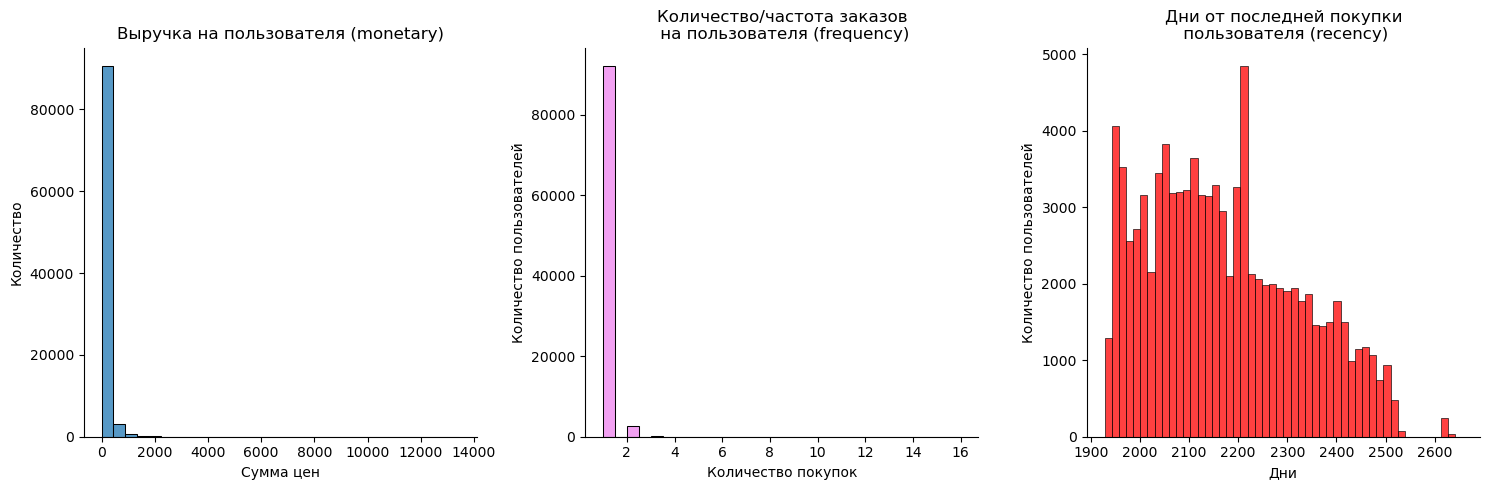

In [31]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

sns.histplot(data=RFM, x='monetary', bins=30, ax=axes[0])
axes[0].set_title("Выручка на пользователя (monetary)")
axes[0].set_xlabel("Сумма цен")
axes[0].set_ylabel("Количество")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

sns.histplot(data=RFM, x='frequency', bins=30, color='violet', ax=axes[1])
axes[1].set_title("Количество/частота заказов\n на пользователя (frequency)")
axes[1].set_xlabel("Количество покупок")
axes[1].set_ylabel("Количество пользователей")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

sns.histplot(data=RFM, x ='recency', bins=50, color ='red', ax=axes[2])
axes[2].set_title("Дни от последней покупки\n пользователя (recency)")
axes[2].set_xlabel("Дни")
axes[2].set_ylabel("Количество пользователей")
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

plt.tight_layout()

- Для метрики R <b>(recency)</b>: чем меньше времени прошло с последнего заказа тем лучше, значит
создадим функцию, которая значения метрики будет распределять по кластерам: чем ниже значение метрики, тем выше кластер,
создается 5 кластеров согласно полученным квинтилям на предыдущем шаге

- Для метрики m <b>(monetary)</b> ситуация обратная: чем больше выручка на пользователя, тем лучше, значит
создадим функцию, которая значения метрики будет распределять по кластерам: чем выше значение метрики, тем выше кластер,
создается 5 кластеров согласно полученным квинтилям на предыдущем шаге

- Для метрики f <b>(frequency)</b> кластеры создаются, как было описано выше: 
 1 покупка, от 2 до 3, от 4 до 5, от 6 до 10 и более 10 заказов
 Чем больше заказов, тем выше кластер, в соответствии с задаными границам (кластеры 1,2,3,4,5)

In [32]:
# recency
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

# monetary
def m_score(x):
    if x <= quintiles['monetary'][.2]:
        return 1
    elif x <= quintiles['monetary'][.4]:
        return 2
    elif x <= quintiles['monetary'][.6]:
        return 3
    elif x <= quintiles['monetary'][.8]:
        return 4
    else:
        return 5

# frequency
def f_score(x):
    if 1 <= x < 2:
        return 1
    elif 2 <= x <= 3:
        return 2
    elif 4 <= x <= 5:
        return 3
    elif 6 <= x <= 10:
        return 4
    else:
        return 5

Применяем функции и создаём столбец с RFM-сегментами:

In [33]:
RFM['R'] = RFM['recency'].apply(lambda x: r_score(x))
RFM['F'] = RFM['frequency'].apply(lambda x: f_score(x))
RFM['M'] = RFM['monetary'].apply(lambda x: m_score(x))

RFM['RFM_Score'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM.head(6)

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score
0,ff22e30958c13ffe219db7d711e8f564,1928,2,290.00,5,2,5,525
1,fb7e29c65321441231990afc201c1b14,1933,2,268.69,5,2,5,525
2,f80013faf776e37bcea7634d59c2181e,1933,1,65.00,5,1,2,512
3,36a5c01d940c382346247b3e6c485c2d,1933,1,29.99,5,1,1,511
4,afbcfd0b9c5233e7ccc73428526fbb52,1933,1,457.75,5,1,5,515
5,b701bebbdf478f5500348f03aff62121,1933,1,24.90,5,1,1,511


##### Смотрим на таблицу. Получен столбец с RFM-сегментами 
- Первая цифра (R) отражает время, прошедшее с последней покупки:
1: прошло более 2210 дней
2: более 2094, но менее 2210 дней
3: прошло более 2003, но менее 2094 дней
4: прошло более 1919, но менее 2003 дней
5: прошло менее 1919 дней

- Вторая цифра (F) отражает количество покупок:
1: совершена 1 покупка, 
2: совершено 2 или 3 покупки
3: совершено 4 или 5 покупок
4: совершено от 6 до 10 покупок
5: совершено более 10 покупок

- Третья цифра (M) отражает общую выручку на покупателя (примем, что валюта - доллар, тк данные для США):
1: выручка менее $39,9, первый квинтиль, 
2: выручка более $39.9, но менее $69.9 , второй квинтиль
3: выручка более $69.9, но менее $109.9 , третий квинтиль
4: выручка более $109.9, но менее $179.9 , четвертый квинтиль
5: выручка более $179.9, пятый квинтиль

Таким образом, чем выше RFM-score, тем лучше покупатель (чаще покупает, большще тратит, меньше времени прошло с последней покупки)
То есть, например:
покупатель с RFM-Score 415:
Совершил последнюю покупку от 1919 до 2003 дней назад, эта покупка была единственной, но принесла более $179.9.